In [213]:
import os
os.chdir('/home/evlasova/covid-t-cell-classifier')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.decomposition import PCA
from scipy.stats import fisher_exact, chi2_contingency
from sklearn.manifold import TSNE, MDS
from tqdm import tqdm
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, precision_score, recall_score, roc_curve
from multipy.fwer import sidak, hochberg
import random

from source.viz_utils import plot_usage_matrix_pca, plot_boxplots_for_usage_matrix, _plot_feature_importance, plot_v_usage_hist, \
                                plot_cluster_map, significant_clones_distribution, plot_results_for_hla_class, plot_generated_to_real_distribution, \
                            plot_olga_cleanup_data, plot_clusters_of_clonotypes, plot_cooccurence_heatmap_with_epitopes_labeling, plot_waterfall_by_column, \
                            plot_feature_importances
from source.usage_matrix_preprocessing import prepare_usage_matrix
from source.ml_utils import get_parameters, prepare_data, evaluate_models, split_data_by_batch, cross_validation_between_batches, make_hla_predictor
from source.data_utils import prepare_run_column
from source.stats_utils import evaluate_anova_testing, evaluate_mannwhitneyu_testing
from source.clustering_utils import seqs2hamming
from source.weblogo_utils import create_web_logo


import warnings
warnings.filterwarnings('ignore')


import importlib
imported_module = importlib.import_module("source.viz_utils")
importlib.reload(imported_module)

<module 'source.viz_utils' from '/home/evlasova/covid-t-cell-classifier/source/viz_utils.py'>

# Training separate α/β classifiers

In [2]:
data_beta = prepare_data(run_to_number_of_clones_path='data/run_to_number_of_clonotypes.csv',
                     desc_path='data/desc_fmba_not_nan_hla.csv',
                     clonotype_matrix_path='data/hla_sign_clone_matrix/covid_clonotype_matrix_500k_top_1_mismatch_hla_all_fisher_wo_leaks_diagonal.csv',
                     hla_keys_path='data/hla_keys.csv',
                     make_freq=True, 
                     use_hla_clones=False, 
                     use_hla_bool=True, 
                     make_all_features_bool=True, 
                     use_standardization=True)
X_train, y_train, X_test, y_test = split_data_by_batch(data=data_beta, 
                                                       test_batches=['2020/10_FMBA_NovaSeq6'], 
                                                       y_column='covid', 
                                                       batch_column='folder')
best_clfs_beta = evaluate_models(X_train, y_train, X_test, y_test, get_parameters(), scoring_function='f1_weighted', debug=True)

Started evaluating svm
Best params for svm: {'model__C': 5, 'model__kernel': 'rbf', 'model__probability': True, 'model__random_state': 42}
Test f1-score for the best model 0.67

Started evaluating ab
Best params for ab: {'model__base_estimator': DecisionTreeClassifier(max_depth=3), 'model__n_estimators': 25, 'model__random_state': 42}
Test f1-score for the best model 0.58

Started evaluating knn
Best params for knn: {'model__leaf_size': 1, 'model__n_neighbors': 10, 'model__weights': 'uniform'}
Test f1-score for the best model 0.64

Started evaluating rfc
Best params for rfc: {'model__max_depth': 3, 'model__min_samples_leaf': 8, 'model__n_estimators': 75, 'model__oob_score': False, 'model__random_state': 42}
Test f1-score for the best model 0.63

Started evaluating mlpclassifier
Best params for mlpclassifier: {'model__alpha': 0.001, 'model__hidden_layer_sizes': (100, 60, 30, 10), 'model__learning_rate': 'constant', 'model__max_iter': 1000, 'model__random_state': 42}
Test f1-score for th

In [ ]:
data_alpha = prepare_data(run_to_number_of_clones_path='data/run_to_number_of_clonotypes_alpha.csv',
                     desc_path='data/desc_fmba_not_nan_hla.csv',
                     clonotype_matrix_path='data/alpha/covid_clonotype_matrix_500k_top_1_mismatch_hla_all_fisher_fmba_alpha_wo_leaks_diagonal.csv',
                     hla_keys_path='data/hla_keys.csv',
                     make_freq=True,
                     use_hla_clones=False,
                     use_hla_bool=True,
                     make_all_features_bool=True,
                     use_standardization=True)
X_train_alpha, y_train_alpha, X_test_alpha, y_test_alpha = split_data_by_batch(data=data_alpha, 
                                                       test_batches=['2020/10_FMBA_NovaSeq6'], 
                                                       y_column='covid', 
                                                       batch_column='folder')

best_clfs_alpha = evaluate_models(X_train_alpha, y_train_alpha, 
                                  X_test_alpha, y_test_alpha, 
                                  get_parameters(), scoring_function='f1_weighted', debug=True)

Started evaluating svm
Best params for svm: {'model__C': 5, 'model__kernel': 'rbf', 'model__probability': True, 'model__random_state': 42}
Test f1-score for the best model 0.69

Started evaluating ab


# Training joint αβ classifier

In [104]:
data_alpha_for_joint = prepare_data(run_to_number_of_clones_path='data/run_to_number_of_clonotypes_alpha.csv',
                     desc_path='data/desc_fmba_not_nan_hla.csv',
                     clonotype_matrix_path='data/alpha/covid_clonotype_matrix_500k_top_1_mismatch_hla_all_fisher_fmba_alpha_wo_leaks_diagonal.csv',
                     hla_keys_path='data/hla_keys.csv',
                     make_freq=True,
                     use_hla_clones=False,
                     use_hla_bool=False,
                     make_all_features_bool=True,
                     use_standardization=True)
print('alpha ready')
data_beta_for_joint = prepare_data(run_to_number_of_clones_path='data/run_to_number_of_clonotypes.csv',
                     desc_path='data/desc_fmba_not_nan_hla.csv',
                     clonotype_matrix_path='data/hla_sign_clone_matrix/covid_clonotype_matrix_500k_top_1_mismatch_hla_all_fisher_wo_leaks_diagonal.csv',
                     hla_keys_path='data/hla_keys.csv',
                     make_freq=True, 
                     use_hla_clones=False, 
                     use_hla_bool=True, 
                     make_all_features_bool=True, 
                     use_standardization=True)
data_joint = pd.concat([data_beta_for_joint[[x for x in data_beta_for_joint.columns if x.startswith('CAS')]], data_alpha_for_joint], axis=1)


X_train_joint, y_train_joint, X_test_joint, y_test_joint = split_data_by_batch(data=data_joint, 
                                                       test_batches=['2020/10_FMBA_NovaSeq6'], 
                                                       y_column='covid', 
                                                       batch_column='folder')

best_clfs_joint = evaluate_models(X_train_joint, y_train_joint, X_test_joint, y_test_joint, 
                                  get_parameters(), scoring_function='f1_weighted', debug=True)

alpha ready
Started evaluating svm
Best params for svm: {'model__C': 1, 'model__kernel': 'linear', 'model__probability': True, 'model__random_state': 42}
Test f1-score for the best model 0.64

Started evaluating ab
Best params for ab: {'model__base_estimator': DecisionTreeClassifier(max_depth=1), 'model__n_estimators': 150, 'model__random_state': 42}
Test f1-score for the best model 0.63

Started evaluating knn
Best params for knn: {'model__leaf_size': 1, 'model__n_neighbors': 10, 'model__weights': 'uniform'}
Test f1-score for the best model 0.65

Started evaluating rfc
Best params for rfc: {'model__max_depth': 3, 'model__min_samples_leaf': 8, 'model__n_estimators': 125, 'model__oob_score': False, 'model__random_state': 42}
Test f1-score for the best model 0.63

Started evaluating mlpclassifier
Best params for mlpclassifier: {'model__alpha': 1e-05, 'model__hidden_layer_sizes': (100, 50, 25, 10), 'model__learning_rate': 'constant', 'model__max_iter': 1000, 'model__random_state': 42}
Tes

# Training classifiers based on metaclones

In [12]:
data_beta_meta = prepare_data(run_to_number_of_clones_path='data/run_to_number_of_clonotypes.csv',
                     desc_path='data/desc_fmba_new_split.csv',
                     clonotype_matrix_path='data/metaclone/beta_cm_metaclone.csv',
                     hla_keys_path='data/hla_keys.csv',
                     make_freq=True,
                     use_hla_clones=False,
                     use_hla_bool=True,
                     make_all_features_bool=True,
                     use_standardization=True)

data_alpha_meta = prepare_data(run_to_number_of_clones_path='data/run_to_number_of_clonotypes_alpha.csv',
                     desc_path='data/desc_fmba_new_split.csv',
                     clonotype_matrix_path='data/metaclone/alpha_cm_metaclone.csv',
                     hla_keys_path='data/hla_keys.csv',
                     make_freq=True,
                     use_hla_clones=False,
                     use_hla_bool=True,
                     make_all_features_bool=True,
                     use_standardization=True)

data_beta_meta = data_beta_meta.rename(columns={f'cluster_{x}': f'b_cluster_{x}' for x in range(23)})
data_alpha_meta = data_alpha_meta.rename(columns={f'cluster_{x}': f'a_cluster_{x}' for x in range(140)})
data_joint_meta = pd.concat([data_beta_meta[[x for x in data_beta_meta.columns if x.startswith('b')]], data_alpha_meta], axis=1)

In [13]:
X_train_beta_m, y_train_beta_m, X_test_beta_m, y_test_beta_m = split_data_by_batch(data=data_beta_meta, 
                                                       test_batches=['2020/10_FMBA_NovaSeq6'], 
                                                       y_column='covid', 
                                                       batch_column='folder')
X_train_alpha_m, y_train_alpha_m, X_test_alpha_m, y_test_alpha_m = split_data_by_batch(data=data_alpha_meta, 
                                                       test_batches=['2020/10_FMBA_NovaSeq6'], 
                                                       y_column='covid', 
                                                       batch_column='folder')
X_train_joint_m, y_train_joint_m, X_test_joint_m, y_test_joint_m = split_data_by_batch(data=data_joint_meta, 
                                                       test_batches=['2020/10_FMBA_NovaSeq6'], 
                                                       y_column='covid', 
                                                       batch_column='folder')

In [92]:
X_test

,CASSLGYEQYF,CASSLGGNQPQHF,CASSLGSNQPQHF,CASSLTGNTEAFF,CASSSSYEQYF,CASSLGGYEQYF,CASSLDRNTEAFF,CASSLSYEQYF,CASSLAGNTEAFF,CASSPSYEQYF,...,DRB1*08,DRB1*03,DRB1*15,DRB1*13,DRB1*04,DRB1*09,DRB1*10,DRB1*14,DRB1*12,DRB1*16
16,1.981483,-0.660062,-0.124668,-0.154976,0.459037,0.501069,-0.990190,1.064956,0.294295,1.089228,...,False,False,True,False,False,False,False,False,False,False
144,-1.471033,-0.423381,-0.630519,-0.545129,-0.458811,-0.595685,-0.252953,-0.611403,-1.426556,-0.257447,...,False,True,True,False,False,False,False,False,False,False
145,-0.402738,0.133884,0.232395,0.141676,-0.613813,-0.022990,-0.505823,-0.753312,-0.613165,0.224421,...,False,False,False,False,True,False,False,False,False,False
146,-0.586081,-0.629192,-0.343377,-0.498625,-0.431043,-0.793092,1.065192,-0.157392,0.348612,-0.499837,...,False,False,False,False,False,False,False,False,False,False
148,-0.388047,-0.349059,-0.998561,1.291338,-0.507970,0.453674,-0.800455,-0.656410,1.111068,-0.651767,...,True,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
909,-0.500125,-0.049798,-1.251328,-1.206440,0.002295,-1.137382,-1.362670,0.124233,-0.242969,-0.117970,...,False,False,False,False,True,False,False,True,False,False
919,-0.240925,-0.952977,-0.675342,0.112909,-0.065876,-0.634797,1.095799,-0.251657,0.595356,0.204238,...,False,False,False,False,True,False,False,False,False,False
920,-0.522886,0.264930,-0.251726,0.453285,0.137373,-0.025190,-0.098578,-0.065576,0.505902,0.443048,...,False,False,False,True,True,False,False,False,False,False
921,-0.420106,0.497554,-0.407495,-0.825221,-0.626063,-0.401082,-0.928893,-0.764528,-0.110191,-0.453962,...,False,False,False,True,False,False,False,False,False,False


In [14]:
best_clfs_beta_m = evaluate_models(X_train_beta_m, y_train_beta_m, X_test_beta_m, y_test_beta_m, 
                                  get_parameters(), scoring_function='f1_weighted', debug=True)

best_clfs_alpha_m = evaluate_models(X_train_alpha_m, y_train_alpha_m, X_test_alpha_m, y_test_alpha_m, 
                                  get_parameters(), scoring_function='f1_weighted', debug=True)

best_clfs_joint_m = evaluate_models(X_train_joint_m, y_train_joint_m, X_test_joint_m, y_test_joint_m, 
                                  get_parameters(), scoring_function='f1_weighted', debug=True)

Started evaluating svm
Best params for svm: {'model__C': 100, 'model__kernel': 'linear', 'model__probability': True, 'model__random_state': 42}
Test f1-score for the best model 0.66

Started evaluating ab
Best params for ab: {'model__base_estimator': DecisionTreeClassifier(max_depth=1), 'model__n_estimators': 25, 'model__random_state': 42}
Test f1-score for the best model 0.61

Started evaluating knn
Best params for knn: {'model__leaf_size': 1, 'model__n_neighbors': 3, 'model__weights': 'uniform'}
Test f1-score for the best model 0.55

Started evaluating rfc
Best params for rfc: {'model__max_depth': 1, 'model__min_samples_leaf': 8, 'model__n_estimators': 50, 'model__oob_score': False, 'model__random_state': 42}
Test f1-score for the best model 0.63

Started evaluating mlpclassifier
Best params for mlpclassifier: {'model__alpha': 0.001, 'model__hidden_layer_sizes': (100, 60, 30, 10), 'model__learning_rate': 'constant', 'model__max_iter': 1000, 'model__random_state': 42}
Test f1-score fo

In [118]:
best_clfs_joint_m = (best_clfs_joint_m[0], best_clfs_joint_m[1], 'svm')

In [152]:
all_clfs = {
     'beta': best_clfs_beta,
     'alpha': best_clfs_alpha,
     'joint': best_clfs_joint,
     'beta_meta': best_clfs_beta_m,
     'alpha_meta': best_clfs_alpha_m,
     'joint_meta': best_clfs_joint_m,
}
X_test_data={
     'beta': X_test,
     'alpha': X_test_alpha,
     'joint': X_test_joint,
     'beta_meta': X_test_beta_m,
     'alpha_meta': X_test_alpha_m,
     'joint_meta': X_test_joint_m,
}
y_test_data={
     'beta': y_test,
     'alpha': y_test_alpha,
     'joint': y_test_joint,
     'beta_meta': y_test_beta_m,
     'alpha_meta': y_test_alpha_m,
     'joint_meta': y_test_joint_m,
}
X_train_data={
     'beta': X_train,
     'alpha': X_train_alpha,
     'joint': X_train_joint,
     'beta_meta': X_train_beta_m,
     'alpha_meta': X_train_alpha_m,
     'joint_meta': X_train_joint_m,
}
y_train_data={
     'beta': y_train,
     'alpha': y_train_alpha,
     'joint': y_train_joint,
     'beta_meta': y_train_beta_m,
     'alpha_meta': y_train_alpha_m,
     'joint_meta': y_train_joint_m,
}

In [246]:
model_df = []
f1_df = []
data_type_df = []
for data_type in ['beta','alpha','joint','beta_meta','alpha_meta','joint_meta']:
    for model in ['svm', 'ab', 'knn', 'rfc', 'mlpclassifier', 'xgboost']:
        cur_score = f1_score(y_test_data[data_type], all_clfs[data_type][0][model].predict(X_test_data[data_type]))
        model_df.append(model)
        data_type_df.append(data_type)
        f1_df.append(cur_score)
comparison_df = pd.DataFrame({'model':model_df, 'f1': f1_df, 'data_type':data_type_df})

In [247]:
comparison_df

,model,f1,data_type
0,svm,0.666667,beta
1,ab,0.579710,beta
2,knn,0.636364,beta
3,rfc,0.627219,beta
4,mlpclassifier,0.647887,beta
5,xgboost,0.676056,beta
6,svm,0.685714,alpha
7,ab,0.693878,alpha
8,knn,0.652778,alpha
9,rfc,0.630952,alpha


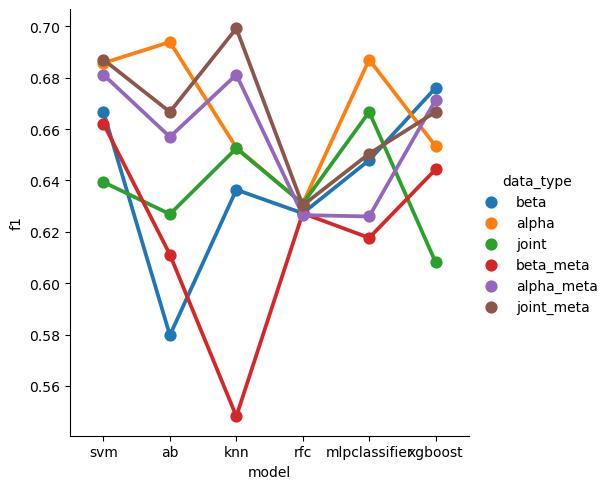

In [251]:
fig, ax = plt.subplots()
sns.catplot(data=comparison_df, x="model", y="f1", hue="data_type", kind="point", ax=ax)
plt.close(1)

<AxesSubplot:xlabel='model', ylabel='f1'>

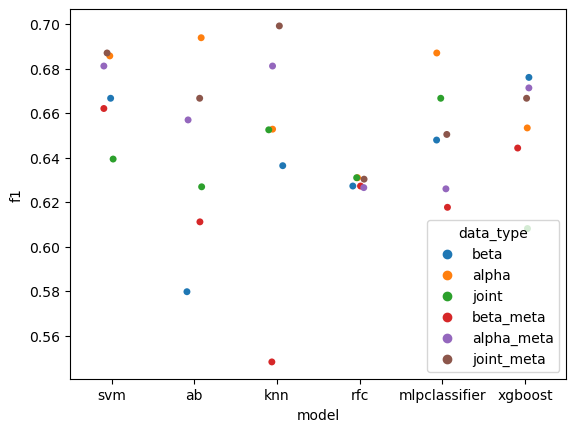

In [256]:
sns.stripplot(data=comparison_df, x="model", y="f1", hue="data_type",)

In [133]:
all_clfs['joint']

({'svm': Pipeline(steps=[('model',
                   SVC(C=1, kernel='linear', probability=True, random_state=42))]),
  'ab': Pipeline(steps=[('model',
                   AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                                      n_estimators=150, random_state=42))]),
  'knn': Pipeline(steps=[('model', KNeighborsClassifier(leaf_size=1, n_neighbors=10))]),
  'rfc': Pipeline(steps=[('model',
                   RandomForestClassifier(max_depth=3, min_samples_leaf=8,
                                          n_estimators=125, random_state=42))]),
  'mlpclassifier': Pipeline(steps=[('model',
                   MLPClassifier(alpha=1e-05,
                                 hidden_layer_sizes=(100, 50, 25, 10),
                                 max_iter=1000, random_state=42))]),
  'xgboost': Pipeline(steps=[('model',
                   XGBClassifier(base_score=None, booster=None, callbacks=None,
                                 colsample_bylevel

# Making metrics dataframe

In [233]:
clf_name = []
clf_type = []
f1 = []
precision = []
recall = []
for key, clfs in all_clfs.items():
    clf_name.append(key)
    clf_type.append(clfs[2])
    best_clf = clfs[0]['svm']
    clf_predictions = best_clf.predict(X_test_data[key])
    f1.append(f1_score(y_test_data[key], clf_predictions))
    precision.append(precision_score(y_test_data[key], clf_predictions))
    recall.append(recall_score(y_test_data[key], clf_predictions))

In [234]:
plotting_df = pd.DataFrame({
    'classifier': clf_name, 
    'best_classifier_predictor': clf_type,
    'f1_score': f1,
    'precision_score': precision,
    'recall_score': recall
})

In [235]:
plotting_df

,classifier,best_classifier_predictor,f1_score,precision_score,recall_score
0,beta,xgboost,0.666667,0.534091,0.886792
1,alpha,ab,0.685714,0.551724,0.905660
2,joint,mlpclassifier,0.639344,0.565217,0.735849
3,beta_meta,svm,0.662069,0.521739,0.905660
4,alpha_meta,svm,0.681159,0.552941,0.886792
5,joint_meta,svm,0.687023,0.576923,0.849057


In [236]:
plotting_df = plotting_df.applymap(lambda x: round(x, 2) if isinstance(x, float) else x)

# Preparing data for proba comparison

In [229]:
beta_predictions = all_clfs['beta'][0]['svm'].predict_proba(X_test_data['beta'])[::,1]
alpha_predictions = all_clfs['alpha'][0]['svm'].predict_proba(X_test_data['alpha'])[::,1]
beta_meta_predictions = all_clfs['beta_meta'][0]['svm'].predict_proba(X_test_data['beta_meta'])[::,1]
alpha_meta_predictions = all_clfs['alpha_meta'][0]['svm'].predict_proba(X_test_data['alpha_meta'])[::,1]
joint_predictions = all_clfs['joint'][0]['svm'].predict_proba(X_test_data['joint'])[::,1]
joint_meta_predictions = all_clfs['joint_meta'][0]['svm'].predict_proba(X_test_data['joint_meta'])[::,1]

proba_labels = y_test.apply(lambda x: 'healthy' if x == 0 else 'covid')
probability_df = pd.DataFrame({
    'beta_proba': beta_predictions,
    'alpha_proba': alpha_predictions,
    'beta_meta_proba': beta_meta_predictions,
    'alpha_meta_proba': alpha_meta_predictions,
    'joint_proba': joint_predictions,
    'joint_meta_proba': joint_meta_predictions,
    'covid': proba_labels
})

In [230]:
probability_df

,beta_proba,alpha_proba,beta_meta_proba,alpha_meta_proba,joint_proba,joint_meta_proba,covid
16,0.784300,0.908177,0.859210,0.722959,0.871391,0.866772,covid
144,0.525311,0.566651,0.714540,0.596644,0.159064,0.426342,covid
145,0.841675,0.600957,0.842661,0.574851,0.629035,0.698659,covid
146,0.692211,0.347721,0.718553,0.286410,0.500000,0.393317,covid
148,0.731511,0.612166,0.713629,0.748928,0.663533,0.823812,covid
...,...,...,...,...,...,...,...
909,0.729067,0.371873,0.845423,0.453720,0.653461,0.567736,healthy
919,0.651388,0.628729,0.691142,0.797077,0.432580,0.720797,healthy
920,0.822252,0.750014,0.737661,0.688436,0.792096,0.758148,healthy
921,0.561059,0.556373,0.591655,0.650265,0.560761,0.409130,healthy


# One folder out CV

In [144]:
metrics_df = []
for metrics, metrics_name in zip([f1_score, precision_score, recall_score], ['f1', 'precision', 'recall']):
    metrics_df.append(cross_validation_between_batches(best_clfs_joint_m[0]['svm'], 
                                 data_joint_meta, 
                                 [x for x in data_joint_meta.folder.unique()], 
                                 y_column='covid', 
                                 batch_column='folder', 
                                 metrics=metrics, 
                                 metrics_name=metrics_name, 
                                 return_metrics_results=True,
                                 ))

In [145]:
metrics_df = metrics_df[0].merge(metrics_df[1]).merge(metrics_df[2])
metrics_df

,folder,f1,precision,recall
0,2020/10_FMBA_NovaSeq5,0.642424,0.530000,0.815385
1,NovaSeq14,0.855932,0.855932,0.855932
2,2020/12_FMBA_Novaseq8_DNA,0.854902,0.865079,0.844961
3,2020/10_FMBA_NovaSeq6,0.687023,0.576923,0.849057
4,2020/12_FMBA_Novaseq7_DNA,0.819512,0.840000,0.800000
5,NovaSeq24,0.897561,0.844037,0.958333
6,NovaSeq34,0.878788,0.844660,0.915789


# Feature importances analysis

In [282]:
data = {'feature_names': X_train_data['joint_meta'].columns}
for mdl in ['ab', 'xgboost', 'rfc']:
    data[mdl] = best_clfs_joint_m[0][mdl]['model'].feature_importances_
fi_df = pd.DataFrame(data)

# Sort the DataFrame in order decreasing feature importance
fi_df.sort_values(by=['xgboost'], ascending=False, inplace=True)
fi_df = fi_df.head(40)
fi_df = fi_df.reset_index(drop=True)

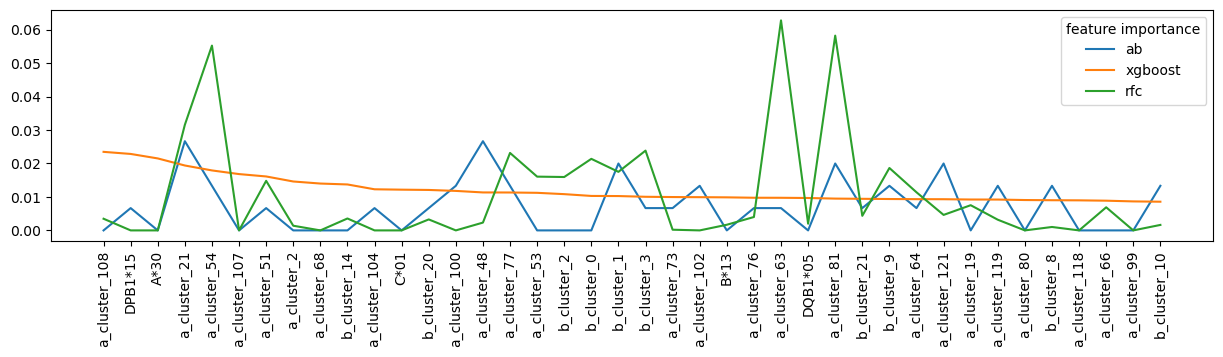

In [305]:
fig, ax = plt.subplots(figsize=(15, 3))
for mdl in ['ab', 'xgboost', 'rfc']:
    ax.plot(fi_df.index, fi_df[mdl], label=mdl)
ax.set_xticks(ticks=range(len(fi_df.index)),
              labels=fi_df.feature_names,
              rotation=90)
ax.legend(title='feature importance')

# Plotting

In [ ]:
for key in all_clfs:
    all_clfs[key][0][all_clfs[key][2]].fit(X_train_data[key], y_train_data[key])

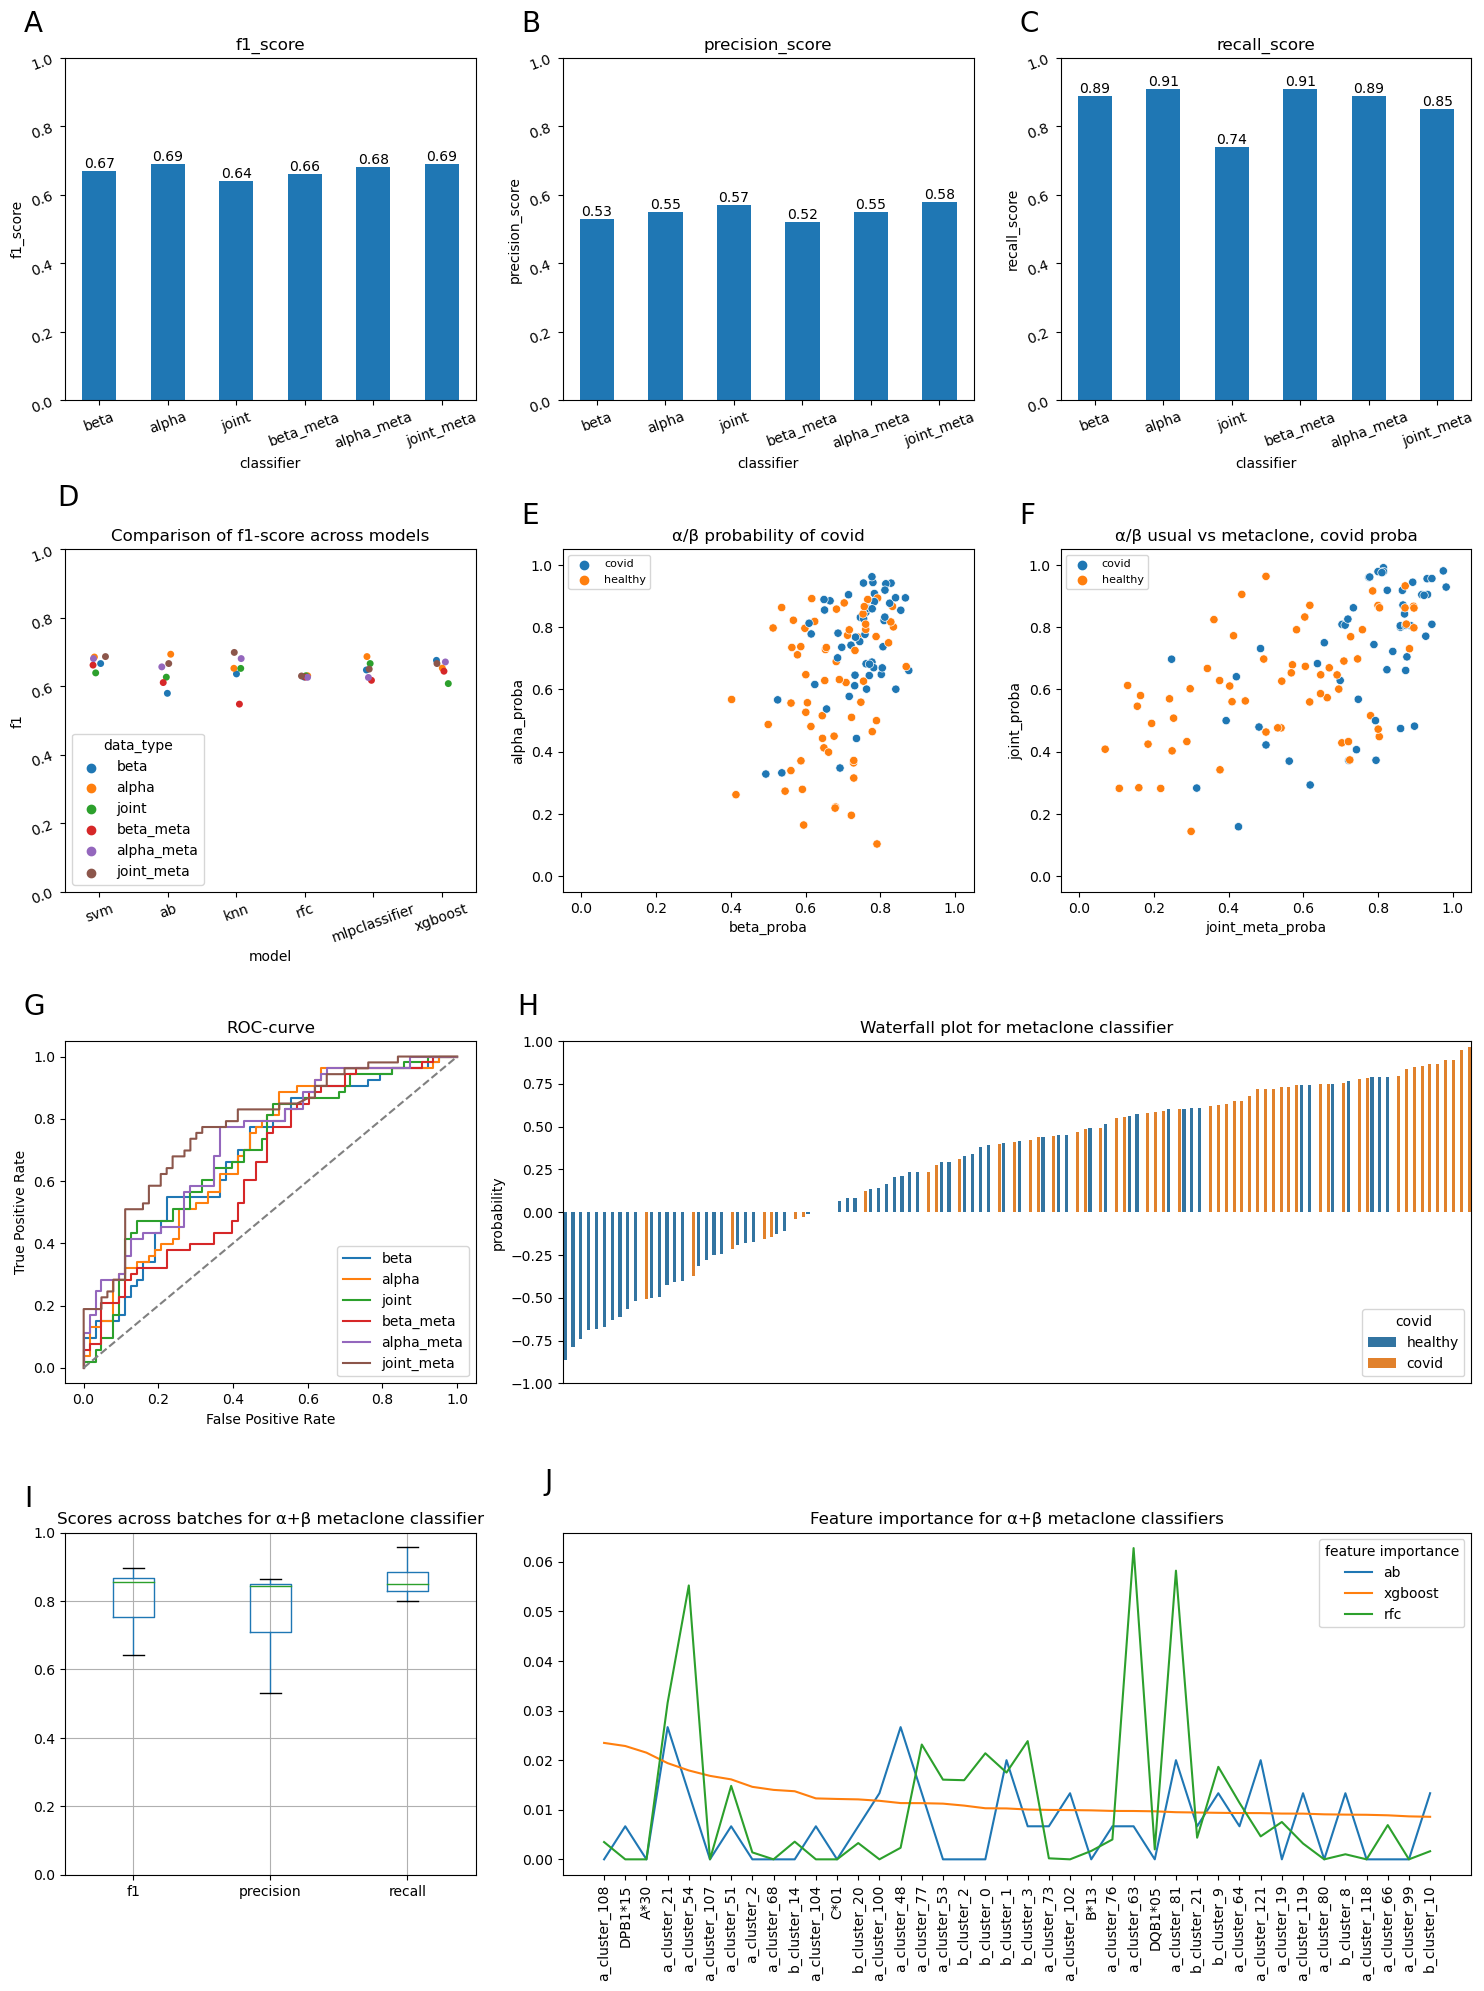

In [307]:
fig = plt.figure(figsize=(15, 20))
gs = GridSpec(nrows=4, 
              ncols=3)
font_size=20
delta_x=-0.1
delta_y=1.14

########################################################

for i, (letter, metrics) in enumerate(zip(['A', 'B', 'C'], ['f1_score', 'precision_score', 'recall_score'])):
    
    ax = fig.add_subplot(gs[0, i])
    plotting_df[['classifier', metrics]].set_index('classifier').plot(kind='bar', ax=ax)
    ax.bar_label(ax.containers[0])
    ax.tick_params(labelrotation=20)
    ax.get_legend().remove()
    ax.set_ylabel(metrics)
    ax.set_title(f'{metrics}')
    ax.tick_params(labelrotation=20)
    ax.set_ylim(0, 1)
    ax.text(delta_x, delta_y, letter,
         horizontalalignment='left',
         verticalalignment='top',
        transform=ax.transAxes,
            size=font_size)

########################################################
ax3 = fig.add_subplot(gs[2, 0])

for key in all_clfs:
    fpr, tpr, _ = roc_curve(y_test_data[key], all_clfs[key][0][all_clfs[key][2]].predict_proba(X_test_data[key])[::,1])
    ax3.plot(fpr,tpr, label=key)

ax3.set_ylabel('True Positive Rate')
ax3.set_xlabel('False Positive Rate')
ax3.plot([0, 1], [0, 1], linestyle='dashed', color='grey')
ax3.legend()
ax3.set_title('ROC-curve')
ax3.text(delta_x, delta_y, 'G',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax3.transAxes,
        size=font_size)

########################################################

ax4 = fig.add_subplot(gs[1, 1])
sns.scatterplot(data=probability_df, x='beta_proba', y='alpha_proba', hue='covid')
ax4.legend(fontsize="8", loc ="upper left")
ax4.set_ylim(-0.05, 1.05)
ax4.set_xlim(-0.05, 1.05)
ax4.set_title('α/β probability of covid')
ax4.text(delta_x, delta_y, 'E',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax4.transAxes,
        size=font_size)

########################################################

ax5 = fig.add_subplot(gs[1, 2])
sns.scatterplot(data=probability_df, x='joint_meta_proba', y='joint_proba', hue='covid')
ax5.legend(fontsize="8", loc ="upper left")
ax5.set_ylim(-0.05, 1.05)
ax5.set_xlim(-0.05, 1.05)
ax5.set_title('α/β usual vs metaclone, covid proba')
ax5.text(delta_x, delta_y, 'F',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax5.transAxes,
        size=font_size)

########################################################

ax6 = fig.add_subplot(gs[2, 1:])
plot_waterfall_by_column(probability_df, proba_column='joint_meta_proba', label_column='covid', ax=ax6)
ax6.set_title('Waterfall plot for metaclone classifier')
ax6.text(delta_x+0.05, delta_y, 'H',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax6.transAxes,
        size=font_size)
ax6.tick_params(bottom=False)
ax6.set_ylim(-1, 1)

########################################################
ax7 = fig.add_subplot(gs[3, 0])

metrics_df.boxplot(ax=ax7)
ax7.set_title('Scores across batches for α+β metaclone classifier')
ax7.set_ylim(0, 1)
ax7.text(delta_x, delta_y, 'I',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax7.transAxes,
        size=font_size)
########################################################

ax8 = fig.add_subplot(gs[3, 1:])
# plot_feature_importances(best_clfs_joint_m[0]['xgboost']['model'],
#                          feature_names=X_train_data['joint_meta'].columns, 
#                          model_type='adaboost', 
#                          k_best=40,
#                          ax=ax8)
for mdl in ['ab', 'xgboost', 'rfc']:
    ax8.plot(fi_df.index, fi_df[mdl], label=mdl)
ax8.set_xticks(ticks=range(len(fi_df.index)),
              labels=fi_df.feature_names,
              rotation=90)
ax8.legend(title='feature importance')
ax8.text(delta_x+0.08, delta_y+0.05, 'J',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax8.transAxes,
        size=font_size)
ax8.set_title('Feature importance for α+β metaclone classifiers')

########################################################

ax9 = fig.add_subplot(gs[1, 0])
sns.stripplot(data=comparison_df, x="model", y="f1", hue="data_type", ax=ax9)
ax9.text(delta_x+0.08, delta_y+0.05, 'D',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax9.transAxes,
        size=font_size)
ax9.set_title('Comparison of f1-score across models')
ax9.tick_params(labelrotation=20)
ax9.set_ylim(0, 1)

########################################################

plt.tight_layout()
plt.savefig("figures/fig4.svg")
plt.savefig("figures/fig4.pdf")
plt.savefig("figures/fig4.png")
plt.show()


Figure 4. Analysis of machine learning approaches applied to FMBA TCRβ and TCRα biomarkers. 

A, B, C. Distribution of target metrics (f1-score, precision, recall) for all the evaluated models.

D. ROC-curve plot for all the evaluated models.

E. The sctterplot describing the relation of the probabilities to label the sample as the COVID-19 positive for TRCα and TCRβ based classifiers.

F. The sctterplot describing the relation of the probabilities to label the sample as the COVID-19 positive for classifier based on both TRCα,TCRβ biomarkers and TRCα,TCRβ metaclone cluster features.

G. The waterfall plot representing the probability of each sample to be labeld as COVID-19 positiove (> 0) or healthy (< 0). Samples coming from healthy donors are colored with blue, COVID-19 samples are colored with orange.

H. Evaluation of target metrics (f1-score, precision, recall) for one batch out cross validation.

I. Feature importance plot for the XGBoost classifier based on TRCα and TCRβ based biomarkers and HLA presence features.